Importing Neccessary Libraries

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Machine Learning Preprocessing and Metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Deep Learning Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Machine Learning Libraries
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# Miscellaneous
import warnings
warnings.filterwarnings("ignore")


Reading CSV file(s)

In [2]:
stock_list = []
company_name = ['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'NVDA']

for i in company_name:
    d = pd.read_csv(i + '.csv')
    stock_list.append(d)

dataset1 = pd.concat(stock_list, axis = 0, ignore_index = True)

dataset = pd.DataFrame(dataset1).groupby('Date').agg({'Open':'mean', 'High':'mean', 'Low':'mean', 
                                                      'Close':'mean', 'Volume':'mean', 
                                                     'Dividends':'mean', 'Stock Splits':'mean'})

Shape of dataset

In [3]:
print("\nDataset Shape / Size")
print("----------------------")
print("Dataset Shape: ", dataset.shape)
print("         Row : ", len(dataset.index))
print("      Column : ", len(dataset.columns))

dataset.head(5)


Dataset Shape / Size
----------------------
Dataset Shape:  (10484, 7)
         Row :  10484
      Column :  7


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12,0.100178,0.100614,0.100178,0.100178,469033600.0,0.0,0.0
1980-12-15,0.095388,0.095388,0.094952,0.094952,175884800.0,0.0,0.0
1980-12-16,0.088418,0.088418,0.087983,0.087983,105728000.0,0.0,0.0
1980-12-17,0.090160,0.090596,0.090160,0.090160,86441600.0,0.0,0.0
1980-12-18,0.092774,0.093210,0.092774,0.092774,73449600.0,0.0,0.0


Dataset description

In [4]:
dataset.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,10483.000000,10483.000000,10483.000000,10483.000000,1.048300e+04,10484.000000,10484.000000
mean,21.037068,21.321294,20.743693,21.037456,1.548524e+08,0.000943,0.000967
std,32.451767,32.870370,32.010217,32.448573,1.628807e+08,0.010633,0.033938
min,0.038765,0.038765,0.038329,0.038329,0.000000e+00,0.000000,0.000000
25%,0.252161,0.258562,0.246706,0.252420,6.005849e+07,0.000000,0.000000
50%,8.791608,8.972038,8.601623,8.802916,1.201928e+08,0.000000,0.000000
75%,24.594796,24.967835,24.248951,24.645626,1.937670e+08,0.000000,0.000000
max,172.327574,173.430638,169.585113,171.665993,4.190480e+09,0.294278,2.000000


Dataset Information

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10484 entries, 1980-12-12 to 2022-07-12
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          10483 non-null  float64
 1   High          10483 non-null  float64
 2   Low           10483 non-null  float64
 3   Close         10483 non-null  float64
 4   Volume        10483 non-null  float64
 5   Dividends     10484 non-null  float64
 6   Stock Splits  10484 non-null  float64
dtypes: float64(7)
memory usage: 655.2+ KB


Correlation between columns

In [6]:
dataset.corr()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Open,1.000000,0.999947,0.999937,0.999874,-0.356422,0.165783,0.010975
High,0.999947,1.000000,0.999899,0.999930,-0.355969,0.165603,0.011173
Low,0.999937,0.999899,1.000000,0.999932,-0.357046,0.165612,0.011048
Close,0.999874,0.999930,0.999932,1.000000,-0.356531,0.165557,0.011197
Volume,-0.356422,-0.355969,-0.357046,-0.356531,1.000000,-0.059440,0.002954
Dividends,0.165783,0.165603,0.165612,0.165557,-0.059440,1.000000,-0.002528
Stock Splits,0.010975,0.011173,0.011048,0.011197,0.002954,-0.002528,1.000000


Data Visualization

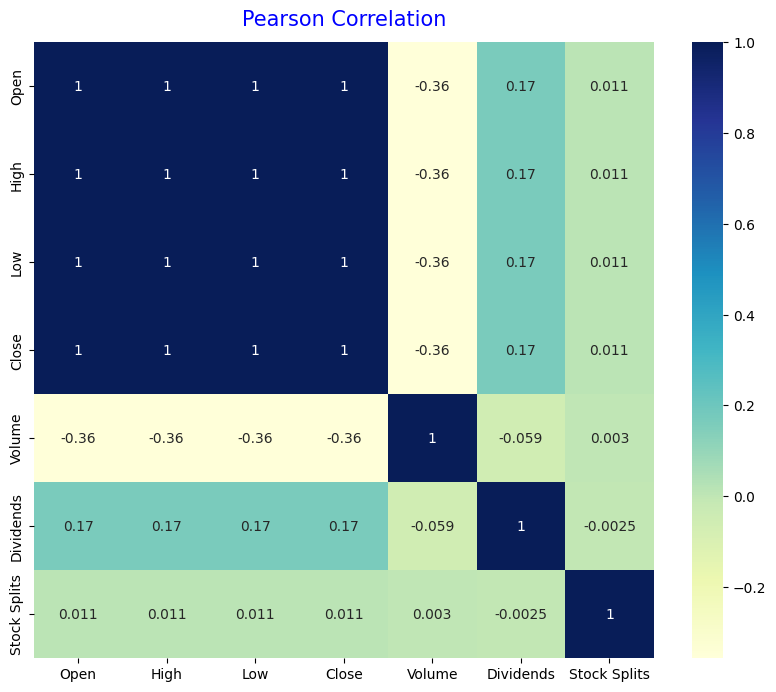

In [7]:
#1) Heatmap

# Visualize the correlation using pearson correlation
plt.figure(figsize = (10,8))
sns.heatmap(dataset.corr(), annot = True, cmap = 'YlGnBu')
plt.title("Pearson Correlation", fontsize = 15, color = 'b', pad = 12, loc = 'center')
plt.savefig('pearson_correlation.png')
plt.show()

In [8]:
sns.set_style('dark')
temp = dataset[['Open', 'Low', 'High', 'Close', 'Volume', 'Dividends', 'Stock Splits']]

Features
--------


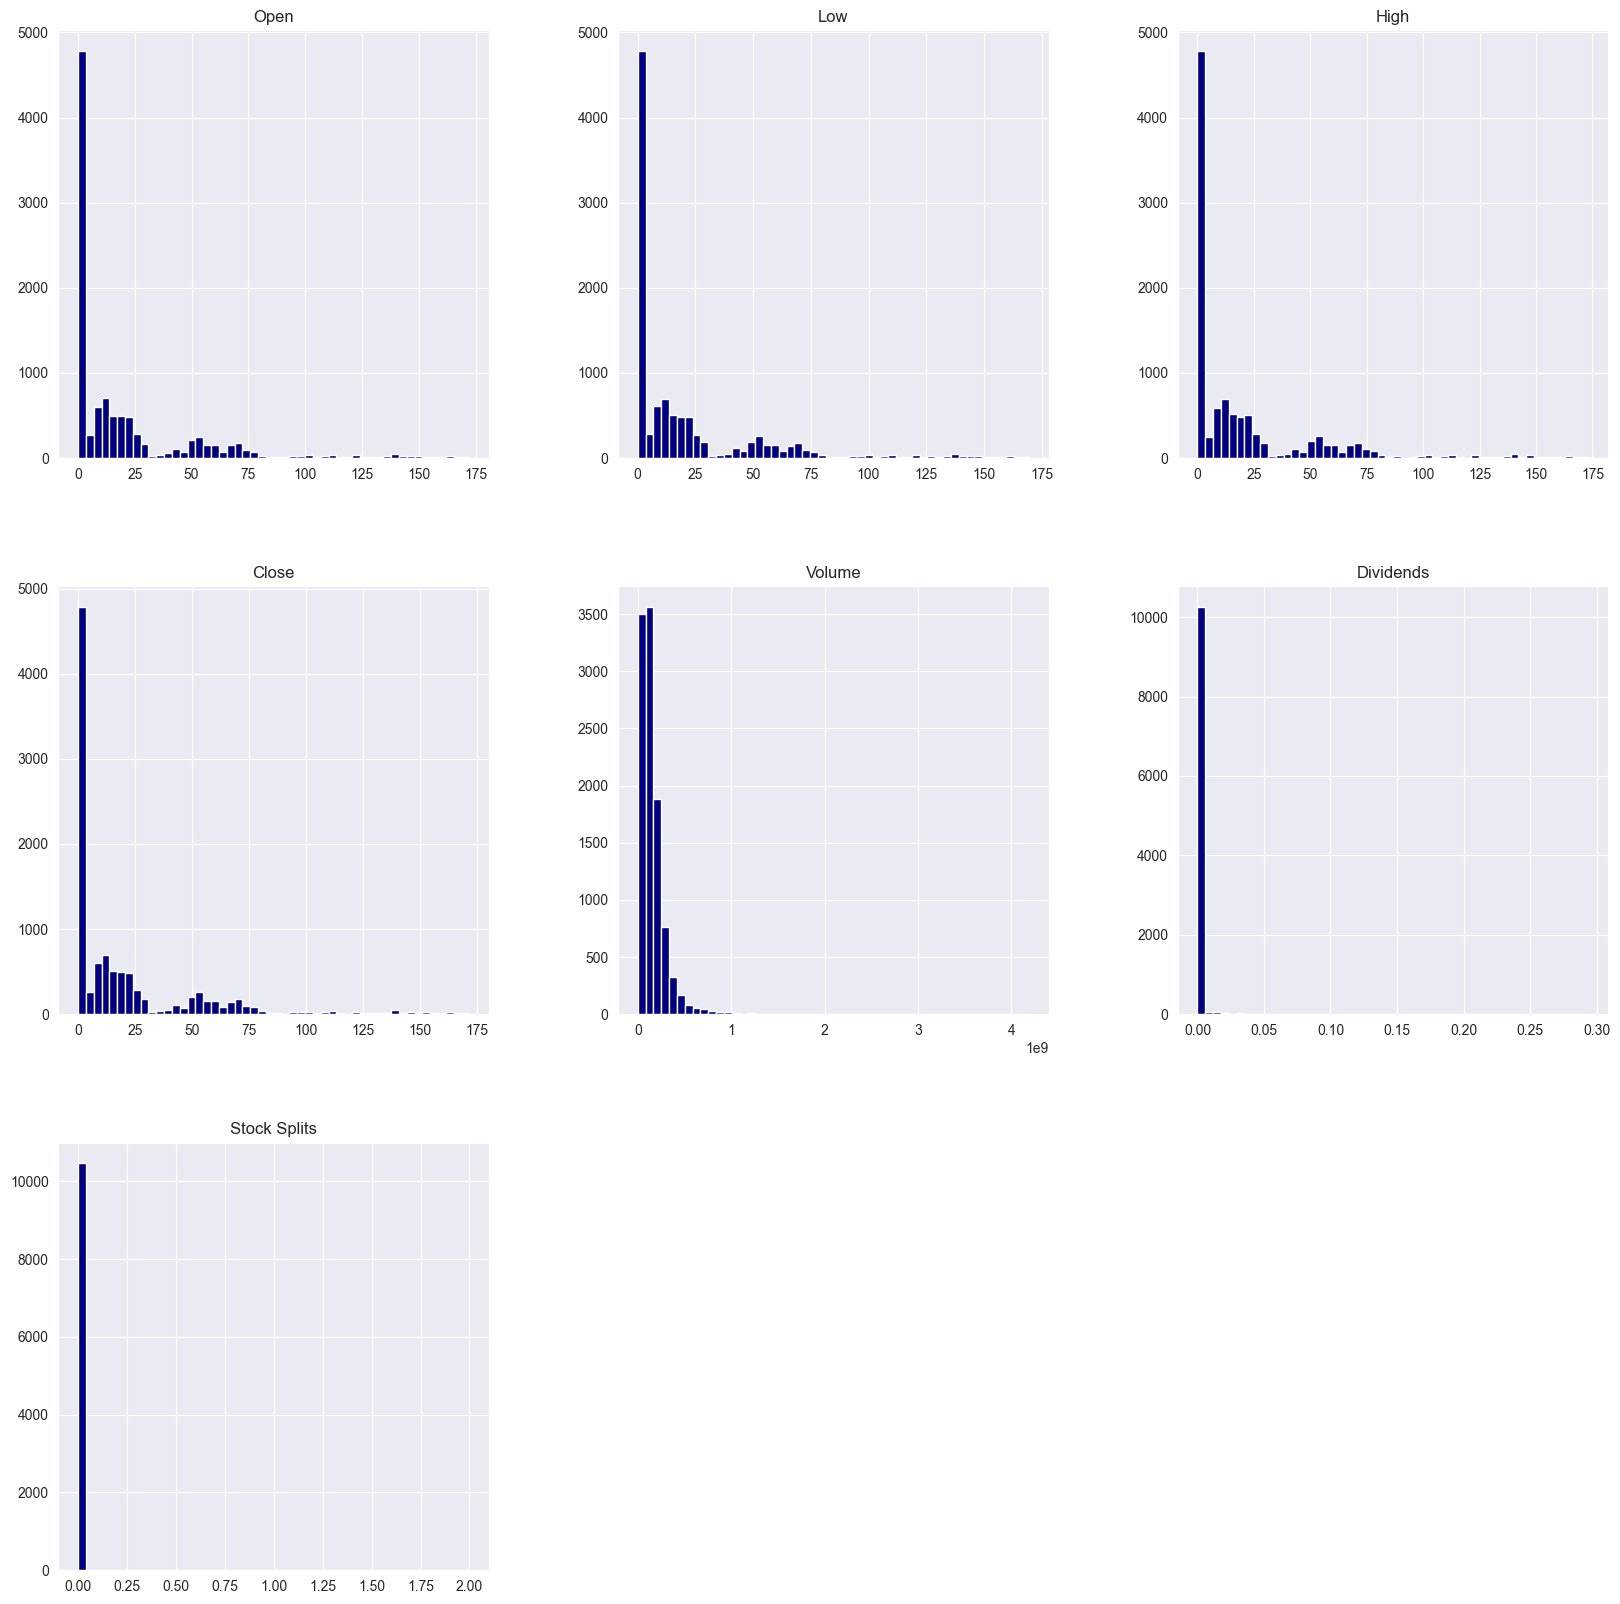

In [9]:
#2) Histogram
print("Features")
print("--------")
temp.hist(bins=50, figsize=(20,20), color='navy');
plt.savefig('histogram.png')  # Save as a PNG file

Select the feautures and target

In [10]:
# Set Target Variable
target = dataset['High']

# Selecting the Features to be scaled later
featuresToBeScaled = ['Open', 'Low', 'Close', 'Volume']

Data Preporcessing

In [11]:
#Dealing with null values

isNullExist = dataset.isnull().any()

if('True' in str(isNullExist)):
    nullData = dataset[dataset.isnull().any(axis=1)]
    print('Before data cleaning')
    print('____________________\n')
    print('Null value exist: True')
    print('\nRow(s) consisting of null values')
    print('--------------------------------')
    print(nullData)

    featuresToBeReplaced = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
    
    for i in featuresToBeReplaced:
        mean_value = 0
        mean_value = dataset[i].mean()
        
        if(i != 'Volume'):
            dataset[i].fillna(value=mean_value, inplace=True)
        else:
            dataset[i].fillna(value=int(mean_value), inplace=True)
    
    print('\n\nAfter data cleaning')
    print('___________________\n')
    nullData = dataset[dataset.isnull().any(axis=1)]
    print(nullData)
    
else:
    print("No missing / null values in dataset")

Before data cleaning
____________________

Null value exist: True

Row(s) consisting of null values
--------------------------------
            Open  High  Low  Close  Volume  Dividends  Stock Splits
Date                                                               
2001-09-12   NaN   NaN  NaN    NaN     NaN        0.0           2.0


After data cleaning
___________________

Empty DataFrame
Columns: [Open, High, Low, Close, Volume, Dividends, Stock Splits]
Index: []


Scaling

In [12]:
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(dataset[featuresToBeScaled])
feature_transform = pd.DataFrame(columns=featuresToBeScaled, data=feature_transform, 
                                 index=dataset.index)
print("\nDataset after scaling:")
print("-----------------------")
print(feature_transform)

output_var = pd.DataFrame(dataset['High'])


Dataset after scaling:
-----------------------
                Open       Low     Close    Volume
Date                                              
1980-12-12  0.000356  0.000365  0.000360  0.111928
1980-12-15  0.000329  0.000334  0.000330  0.041972
1980-12-16  0.000288  0.000293  0.000289  0.025231
1980-12-17  0.000298  0.000306  0.000302  0.020628
1980-12-18  0.000313  0.000321  0.000317  0.017528
...              ...       ...       ...       ...
2022-07-06  0.737935  0.740848  0.741295  0.006573
2022-07-07  0.740314  0.749115  0.755453  0.006250
2022-07-08  0.745345  0.754403  0.754948  0.005769
2022-07-11  0.746138  0.748220  0.745499  0.005506
2022-07-12  0.743932  0.746815  0.744596  0.008173

[10484 rows x 4 columns]


Splitting to Training set and Test set

In [13]:
timesplit = TimeSeriesSplit(n_splits=10)

for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): 
                                                (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): 
                                                (len(train_index)+len(test_index))].values.ravel()

Implementing the SVM model

In [14]:
svm_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)

Fitting the model

In [15]:
svm_model.fit(X_train, y_train)

SVR(C=100, gamma=0.1)

Predicting using the SVM model

In [16]:
y_pred = svm_model.predict(X_test)

Plotting the Actual VS Predicted graph for SVM Model

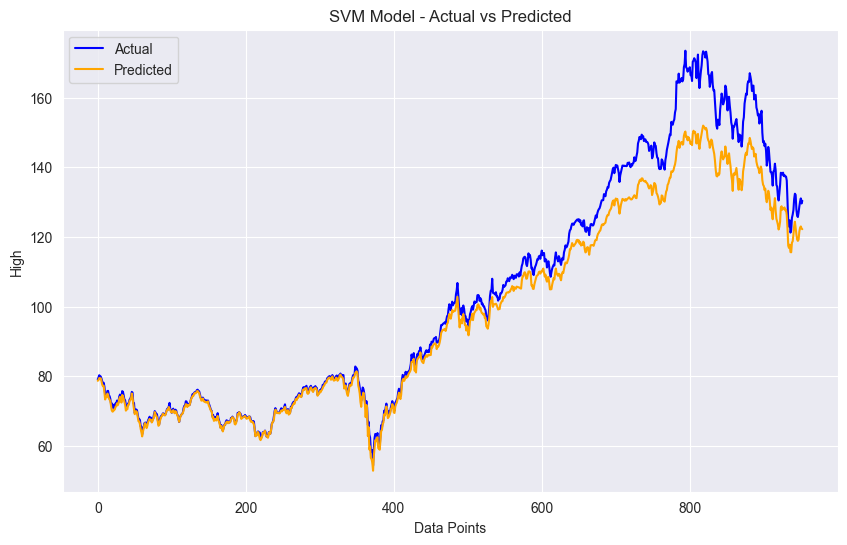

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='orange')
plt.title('SVM Model - Actual vs Predicted')
plt.xlabel('Data Points')
plt.ylabel('High')
plt.legend()
plt.grid(True)
plt.savefig('SVM.png')
plt.show()

Evaluating the SVM model

In [18]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print("SVM Model Evaluation Metrics")
print("-----------------------------------")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared Score (R²): {r2:.4f}")

SVM Model Evaluation Metrics
-----------------------------------
Mean Absolute Error (MAE): 5.0309
Mean Squared Error (MSE): 59.5746
Root Mean Squared Error (RMSE): 7.7185
R-squared Score (R²): 0.9478


Implementing the Random Forest Regressor

In [19]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

Fitting the model

In [20]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=42)

Predicting using Random Forest model

In [21]:
y_pred = rf_model.predict(X_test)

Plotting the Actual vs Predicted for Random Forest model

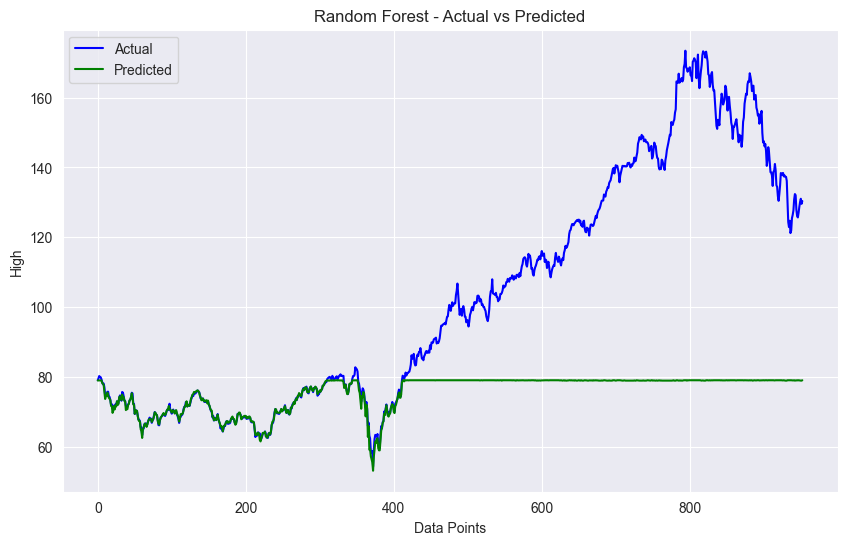

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='green')
plt.title('Random Forest - Actual vs Predicted')
plt.xlabel('Data Points')
plt.ylabel('High')
plt.legend()
plt.grid(True)
plt.savefig('RF.png')
plt.show()

Evaluating the Random Forest model

In [23]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print("Random Forest Model Evaluation Metrics")
print("-----------------------------------")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared Score (R²): {r2:.4f}")

Random Forest Model Evaluation Metrics
-----------------------------------
Mean Absolute Error (MAE): 27.5821
Mean Squared Error (MSE): 1686.8755
Root Mean Squared Error (RMSE): 41.0716
R-squared Score (R²): -0.4770


Implementing the ANN

In [24]:
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),  # Input layer with 64 neurons
    Dropout(0.2),  # Dropout for regularization
    Dense(32, activation='relu'),  # Hidden layer with 32 neurons
    Dense(1, activation='linear')  # Output layer for regression
])

Compiling the model

In [25]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Training the model

In [26]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 63.9958 - mae: 5.2937 - val_loss: 635.0094 - val_mae: 23.0244
Epoch 2/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.9652 - mae: 2.1917 - val_loss: 57.9137 - val_mae: 6.4896
Epoch 3/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0489 - mae: 0.7592 - val_loss: 28.6066 - val_mae: 4.5338
Epoch 4/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8527 - mae: 0.5944 - val_loss: 18.5839 - val_mae: 3.7139
Epoch 5/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6849 - mae: 0.5103 - val_loss: 9.6738 - val_mae: 2.6874
Epoch 6/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6307 - mae: 0.4685 - val_loss: 2.7122 - val_mae: 1.3161
Epoch 7/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5677 - mae: 0.4201 - val_loss: 1.7680 - val_mae: 1.0894
Epoch 8/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5962 - mae: 0.4223 - val_loss: 1.1239 - val_mae: 0.9228
Epoch 9/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 

Predicting using ANN model

In [27]:
y_pred = model.predict(X_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Plotting the Loss during Training graph for ANN

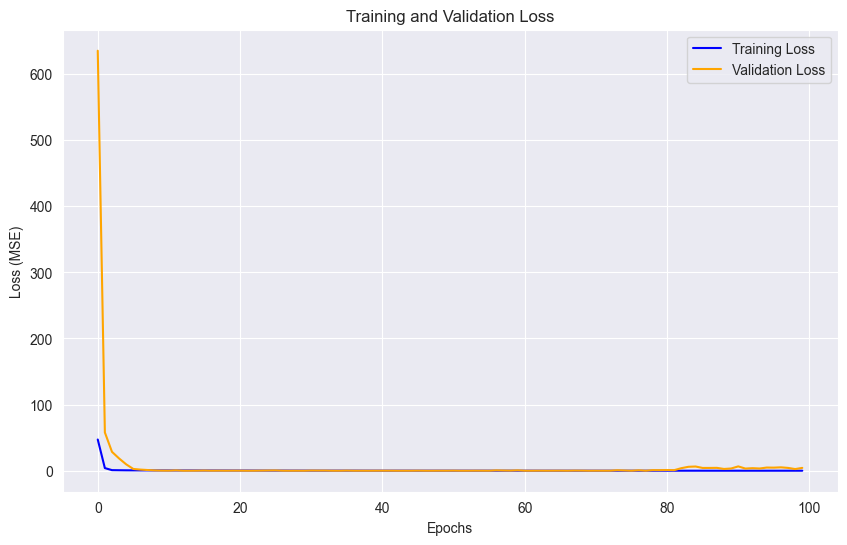

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.savefig('ANN_T_vs_VL.png') 
plt.grid(True)
plt.show()

Plotting the Actual vs Predicted graph using ANN

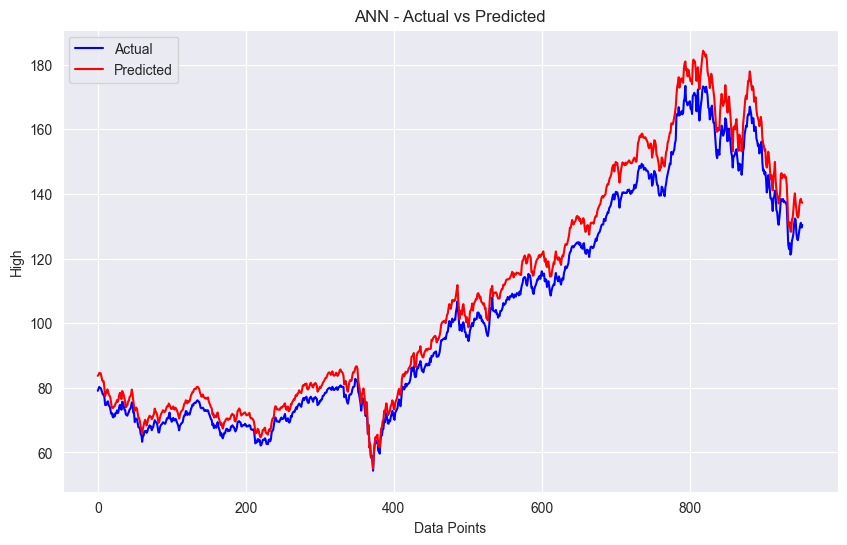

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.title('ANN - Actual vs Predicted')
plt.xlabel('Data Points')
plt.ylabel('High')
plt.legend()
plt.grid(True)
plt.savefig('ANN.png') 
plt.show()

Evaluating the ANN model

In [30]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print("ANN Model Evaluation Metrics")
print("-----------------------------------")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared Score (R²): {r2:.4f}")

ANN Model Evaluation Metrics
-----------------------------------
Mean Absolute Error (MAE): 5.5748
Mean Squared Error (MSE): 36.8035
Root Mean Squared Error (RMSE): 6.0666
R-squared Score (R²): 0.9678


Implementing LSTM Model

Reshape data for LSTM

In [31]:
# LSTM requires input shape as (samples, timesteps, features)
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

Building the LSTM model

In [32]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True),
    Dropout(0.2),  # Dropout for regularization
    LSTM(50, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Output layer for regression
])

Compiling the model

In [33]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Training the model

In [34]:
history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 75.4129 - mae: 5.2510 - val_loss: 762.0477 - val_mae: 25.8214
Epoch 2/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 26.5883 - mae: 4.6291 - val_loss: 32.5934 - val_mae: 4.4746
Epoch 3/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.7792 - mae: 1.7166 - val_loss: 108.2552 - val_mae: 8.2956
Epoch 4/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.1222 - mae: 1.2099 - val_loss: 79.1358 - val_mae: 6.8884
Epoch 5/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.5935 - mae: 1.0533 - val_loss: 86.7434 - val_mae: 7.2893
Epoch 6/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2917 - mae: 0.9867 - val_loss: 73.4389 - val_mae: 6.6349
Epoch 7/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.1792 - mae: 0.9406 - val_loss: 59.5463 - val_mae: 5.9263
Epoch 8/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.3015 - mae: 0.9574 - val_loss: 51.8842 - val_mae: 5.4749
Epoch 9/100
239/239 ━━━━━━━━━━━━━━━

Predicting using the LSTM model

In [35]:
y_pred = model.predict(X_test_reshaped)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


Plotting the Loss during Training graph for LSTM

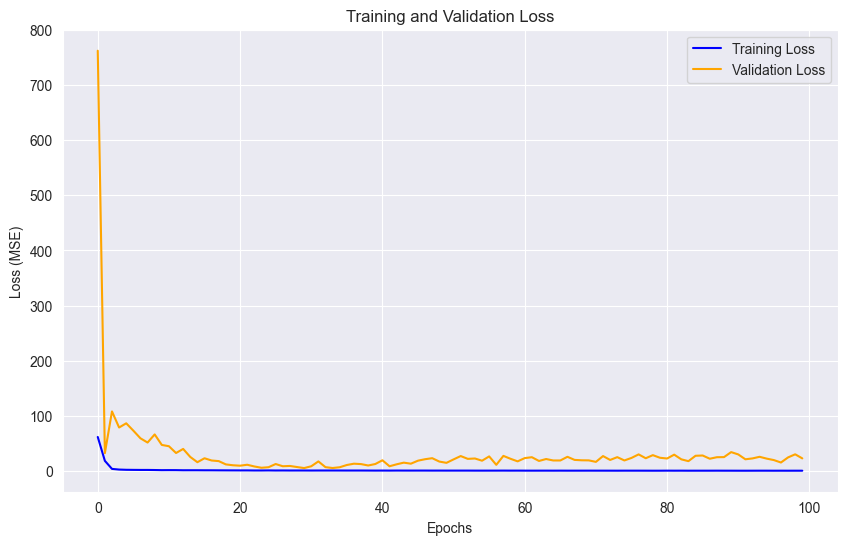

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.savefig('LSTM_T_vs_VL.png')  # Save as a PNG file
plt.show()

Plotting the Actual vs Predicted graph for LSTM

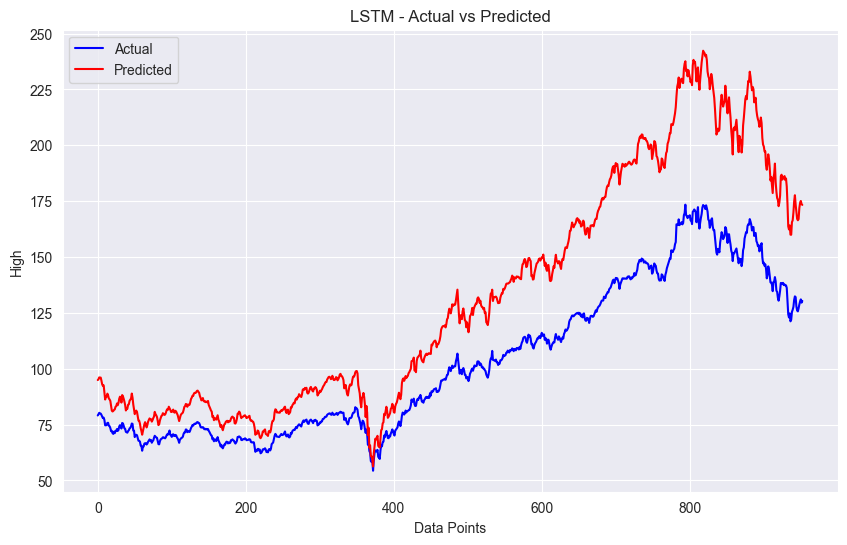

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.title('LSTM - Actual vs Predicted')
plt.xlabel('Data Points')
plt.ylabel('High')
plt.legend()
plt.grid(True)
plt.savefig('LSTM.png')  # Save as a PNG file
plt.show()

Evaluating the LSTM model

In [38]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print("LSTM Model Evaluation Metrics")
print("-----------------------------------")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared Score (R²): {r2:.4f}")

LSTM Model Evaluation Metrics
-----------------------------------
Mean Absolute Error (MAE): 28.5780
Mean Squared Error (MSE): 1169.3244
Root Mean Squared Error (RMSE): 34.1954
R-squared Score (R²): -0.0238
